<a href="https://colab.research.google.com/github/emolinaperez/econometrics_mek/blob/main/Week%205/R/Week5_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Econometrics

In [2]:
# load packages
if (!require(pacman)) install.packages("pacman")
p_load('ggplot2', 'sandwich','lmtest', 'estimatr', 'clubSandwich','stargazer') # clubSandwich: for clustered robust standard errors


Loading required package: pacman

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’



sandwich installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


lmtest installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Formula’, ‘RcppEigen’



estimatr installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


clubSandwich installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


stargazer installed



# 1. Load the dataset  

Peer Effects, Teacher Incentives, and the Impact of Tracking: Evidence from a Randomized Evaluation in Kenya

In [3]:
data <- read.csv("https://raw.githubusercontent.com/emolinaperez/econometrics_mek/main/Week%205/data/DDK2011_corrected.csv")

# 2. Data Cleaning and Preparation

In [4]:
# Check for missing values
summary(data)

    pupilid            schoolid      district            bungoma      
 Min.   : 4301001   Min.   : 430   Length:7022        Min.   :0.0000  
 1st Qu.: 6921029   1st Qu.: 692   Class :character   1st Qu.:0.0000  
 Median : 7951019   Median : 795   Mode  :character   Median :0.0000  
 Mean   : 7831203   Mean   : 783                      Mean   :0.2418  
 3rd Qu.: 9381056   3rd Qu.: 938                      3rd Qu.:0.0000  
 Max.   :10201055   Max.   :1020                      Max.   :1.0000  
                                                                      
   division             zone              tracking           sbm        
 Length:7022        Length:7022        Min.   :0.0000   Min.   :0.0000  
 Class :character   Class :character   1st Qu.:0.0000   1st Qu.:0.0000  
 Mode  :character   Mode  :character   Median :1.0000   Median :1.0000  
                                       Mean   :0.5145   Mean   :0.5084  
                                       3rd Qu.:1.0000   3rd Qu.:1.0

In [5]:
# Filter to include only non-missing total scores
data_clean <- data[!is.na(data$totalscore), ]

# 3. Exploratory Data Analysis

In [6]:
# Summary statistics
str(data_clean)

'data.frame':	5795 obs. of  106 variables:
 $ pupilid                     : int  4301003 4301004 4301005 4301007 4301009 4301010 4301011 4301012 4301013 4301014 ...
 $ schoolid                    : int  430 430 430 430 430 430 430 430 430 430 ...
 $ district                    : chr  "BUNGOMA" "BUNGOMA" "BUNGOMA" "BUNGOMA" ...
 $ bungoma                     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ division                    : chr  "KANDUYI" "KANDUYI" "KANDUYI" "KANDUYI" ...
 $ zone                        : chr  "MUNICIPALITY" "MUNICIPALITY" "MUNICIPALITY" "MUNICIPALITY" ...
 $ tracking                    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sbm                         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ girl                        : int  1 0 0 0 0 1 0 0 1 1 ...
 $ agetest                     : int  8 14 11 10 10 9 10 10 7 10 ...
 $ etpteacher                  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ lowstream                   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ stream_meanpercentile       : num  25.1 25.

# 4. Descriptive Statistics (Replicating Table 1)

In [7]:
descriptive_stats <- function(var) {
  mean_tracking <- mean(data_clean[data_clean$tracking == 1, var], na.rm = TRUE)
  sd_tracking <- sd(data_clean[data_clean$tracking == 1, var], na.rm = TRUE)
  mean_non_tracking <- mean(data_clean[data_clean$tracking == 0, var], na.rm = TRUE)
  sd_non_tracking <- sd(data_clean[data_clean$tracking == 0, var], na.rm = TRUE)
  p_value <- t.test(data_clean[data_clean$tracking == 1, var],
                    data_clean[data_clean$tracking == 0, var])$p.value
  return(c(mean_tracking, sd_tracking, mean_non_tracking, sd_non_tracking, p_value))
}

In [8]:
# Variables to analyze
vars_to_analyze <- c("agetest", "girl", "std_mark", "totalscore")

In [9]:
# Apply the function to the variables
descriptive_results <- t(sapply(vars_to_analyze, descriptive_stats))
colnames(descriptive_results) <- c("Mean_Tracking", "SD_Tracking", "Mean_Non_Tracking", "SD_Non_Tracking", "P_Value")

In [10]:
# Convert to data frame for easier export
descriptive_results_df <- data.frame(Variable = vars_to_analyze, descriptive_results)

In [12]:
# Display the descriptive statistics
descriptive_results_df

,Variable,Mean_Tracking,SD_Tracking,Mean_Non_Tracking,SD_Non_Tracking,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
agetest,agetest,9.41249580,1.4495846,9.23046736,1.4470327,1.836241e-06
girl,girl,0.50219520,0.5000796,0.47974414,0.4996783,8.805998e-02
std_mark,std_mark,0.01328711,0.9808095,0.04470219,0.9777390,2.543251e-01
totalscore,totalscore,13.51444866,9.1654449,12.25625190,9.0102132,1.424393e-07


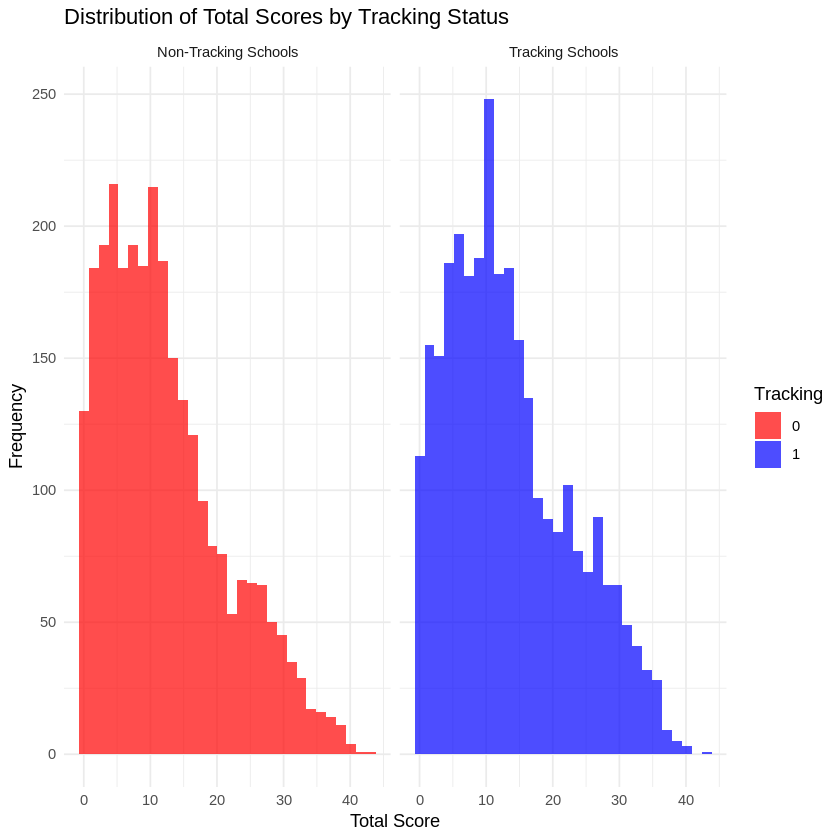

In [15]:
# Visualize the distribution of total scores by tracking status using ggplot
p <- ggplot(data_clean, aes(x = totalscore, fill = factor(tracking))) +
  geom_histogram(position = "dodge", bins = 30, alpha = 0.7) +
  facet_wrap(~tracking, labeller = as_labeller(c(`0` = "Non-Tracking Schools", `1` = "Tracking Schools"))) +
  scale_fill_manual(values = c("red", "blue")) +
  labs(title = "Distribution of Total Scores by Tracking Status",
       x = "Total Score",
       y = "Frequency",
       fill = "Tracking") +
  theme_minimal()
p

# 5. Replicating Key Results (Replicating Table 2)

In [22]:
# Standardize
# Z= X−μ/σ
data_clean$totalscore_std <- scale(data_clean$totalscore)
data_clean$mathscoreraw_std <- scale(data_clean$mathscoreraw)
data_clean$litscore_std <- scale(data_clean$litscore)

In [23]:
# OLS regression for Total Scores
model_ols <- lm(totalscore_std ~ tracking, data = data_clean)
summary(model_ols)


Call:
lm(formula = totalscore_std ~ tracking, data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4833 -0.7921 -0.1858  0.6179  3.3852 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.07104    0.01881  -3.777  0.00016 ***
tracking     0.13809    0.02622   5.266 1.44e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9977 on 5793 degrees of freedom
Multiple R-squared:  0.004764,	Adjusted R-squared:  0.004592 
F-statistic: 27.73 on 1 and 5793 DF,  p-value: 1.444e-07


In [24]:
#formatted summary table of the OLS regression
stargazer(model_ols, type='text')


                        Dependent variable:    
                    ---------------------------
                          totalscore_std       
-----------------------------------------------
tracking                     0.138***          
                              (0.026)          
                                               
Constant                     -0.071***         
                              (0.019)          
                                               
-----------------------------------------------
Observations                   5,795           
R2                             0.005           
Adjusted R2                    0.005           
Residual Std. Error      0.998 (df = 5793)     
F Statistic          27.731*** (df = 1; 5793)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [27]:
# OLS regression for Math Scores
model_math <- lm(mathscoreraw_std ~ tracking, data = data_clean)
summary(model_math)


Call:
lm(formula = mathscoreraw_std ~ tracking, data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6889 -0.8270  0.0350  0.8068  3.4828 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.06449    0.01882  -3.427 0.000614 ***
tracking     0.12537    0.02623   4.779 1.81e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9981 on 5793 degrees of freedom
Multiple R-squared:  0.003927,	Adjusted R-squared:  0.003755 
F-statistic: 22.84 on 1 and 5793 DF,  p-value: 1.808e-06


In [28]:
# formatted summary table of the OLS regression
stargazer(model_math, type='text', title='Table 2: Math Scores')


Table 2: Math Scores
                        Dependent variable:    
                    ---------------------------
                         mathscoreraw_std      
-----------------------------------------------
tracking                     0.125***          
                              (0.026)          
                                               
Constant                     -0.064***         
                              (0.019)          
                                               
-----------------------------------------------
Observations                   5,795           
R2                             0.004           
Adjusted R2                    0.004           
Residual Std. Error      0.998 (df = 5793)     
F Statistic          22.836*** (df = 1; 5793)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [29]:
# OLS regression for Literacy Scores
model_literacy <- lm(litscore_std ~ tracking, data = data_clean)
summary(model_literacy)


Call:
lm(formula = litscore_std ~ tracking, data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0227 -0.7138 -0.4196  0.4464  3.3533 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.06268    0.01882  -3.331  0.00087 ***
tracking     0.12186    0.02624   4.644 3.49e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9982 on 5793 degrees of freedom
Multiple R-squared:  0.00371,	Adjusted R-squared:  0.003538 
F-statistic: 21.57 on 1 and 5793 DF,  p-value: 3.485e-06


In [30]:
# formatted summary table of the OLS regression
stargazer(model_math, type='text', title='Table 3: Literacy Scores')


Table 3: Literacy Scores
                        Dependent variable:    
                    ---------------------------
                         mathscoreraw_std      
-----------------------------------------------
tracking                     0.125***          
                              (0.026)          
                                               
Constant                     -0.064***         
                              (0.019)          
                                               
-----------------------------------------------
Observations                   5,795           
R2                             0.004           
Adjusted R2                    0.004           
Residual Std. Error      0.998 (df = 5793)     
F Statistic          22.836*** (df = 1; 5793)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [31]:
# Robust standard errors
coeftest(model_ols, vcov = vcovHC(model_ols, type = "HC1"))
coeftest(model_math, vcov = vcovHC(model_math, type = "HC1"))
coeftest(model_literacy, vcov = vcovHC(model_literacy, type = "HC1"))


t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -0.071035   0.018642 -3.8105 0.0001401 ***
tracking     0.138091   0.026210  5.2686 1.424e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -0.064489   0.018878 -3.4161 0.0006396 ***
tracking     0.125365   0.026239  4.7778 1.816e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -0.062684   0.018582 -3.3733 0.0007475 ***
tracking     0.121856   0.026219  4.6477 3.431e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# 6. Clustered Robust Standard Errors

In [32]:
# Assuming clustering at the school level (replace 'school_id' with the actual cluster variable)
# Example: Clustered standard errors for total scores
model_clustered <- lm(totalscore_std ~ tracking, data = data_clean)
summary(model_clustered)

cluster_se <- vcovCL(model_clustered, cluster = ~schoolid)
coeftest(model_ols, vcov = cluster_se)



Call:
lm(formula = totalscore_std ~ tracking, data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4833 -0.7921 -0.1858  0.6179  3.3852 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.07104    0.01881  -3.777  0.00016 ***
tracking     0.13809    0.02622   5.266 1.44e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9977 on 5793 degrees of freedom
Multiple R-squared:  0.004764,	Adjusted R-squared:  0.004592 
F-statistic: 27.73 on 1 and 5793 DF,  p-value: 1.444e-07



t test of coefficients:

             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.071035   0.054393 -1.3060  0.19162  
tracking     0.138091   0.077236  1.7879  0.07384 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# 7. Heterogeneous Effects by Achievement Levels

In [33]:
quartile_cutoffs <- quantile(data_clean$percentile, probs = seq(0, 1, by = 0.25), na.rm = TRUE)
data_clean$achievement_quartile <- cut(data_clean$percentile,
                                       breaks = quartile_cutoffs,
                                       include.lowest = TRUE,
                                       labels = 1:4)

In [34]:
# OLS with interaction terms
model_interaction <- lm(totalscore_std ~ tracking * achievement_quartile, data = data_clean)
summary(model_interaction)


Call:
lm(formula = totalscore_std ~ tracking * achievement_quartile, 
    data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1679 -0.6451 -0.1594  0.5417  3.4903 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.671624   0.036884 -18.209  < 2e-16 ***
tracking                        0.136951   0.048816   2.805  0.00504 ** 
achievement_quartile2           0.400758   0.052093   7.693  1.7e-14 ***
achievement_quartile3           0.727577   0.051631  14.092  < 2e-16 ***
achievement_quartile4           1.211934   0.051695  23.444  < 2e-16 ***
tracking:achievement_quartile2  0.022050   0.068994   0.320  0.74929    
tracking:achievement_quartile3 -0.007356   0.068900  -0.107  0.91498    
tracking:achievement_quartile4  0.074451   0.068896   1.081  0.27991    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8798 on 5296 degrees of freedom
  (491 observ

# 8. Peer Effects Analysis

In [35]:
model_peer_effects <- lm(totalscore_std ~ rMEANstream_std_baselinemark, data = data_clean)
summary(model_peer_effects)


Call:
lm(formula = totalscore_std ~ rMEANstream_std_baselinemark, data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8431 -0.7368 -0.1735  0.6149  2.9477 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   0.01155    0.01325   0.871    0.384    
rMEANstream_std_baselinemark  0.48360    0.02152  22.469   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9546 on 5189 degrees of freedom
  (604 observations deleted due to missingness)
Multiple R-squared:  0.08867,	Adjusted R-squared:  0.08849 
F-statistic: 504.9 on 1 and 5189 DF,  p-value: < 2.2e-16


# 9. Regression Discontinuity Analysis (Optional)

In [37]:
rd_data <- data_clean[data_clean$percentile >= 45 & data_clean$percentile <= 55, ]
model_rd <- lm(totalscore ~ tracking, data = rd_data)
summary(model_rd)


Call:
lm(formula = totalscore ~ tracking, data = rd_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.929  -5.775  -1.389   4.829  25.872 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  10.5285     0.4996  21.075  < 2e-16 ***
tracking      2.7002     0.6689   4.037 6.21e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.691 on 534 degrees of freedom
  (491 observations deleted due to missingness)
Multiple R-squared:  0.02961,	Adjusted R-squared:  0.0278 
F-statistic:  16.3 on 1 and 534 DF,  p-value: 6.21e-05


# 10. Tests for Selection on Observables

In [39]:
balance_test <- function(var) {
  t.test(data_clean[data_clean$tracking == 1, var],
         data_clean[data_clean$tracking == 0, var])
}

In [40]:
balance_age <- balance_test("agetest")
balance_gender <- balance_test("girl")
balance_baseline_score <- balance_test("std_mark")
print(balance_age)
print(balance_gender)
print(balance_baseline_score)


	Welch Two Sample t-test

data:  data_clean[data_clean$tracking == 1, var] and data_clean[data_clean$tracking == 0, var]
t = 4.7756, df = 5758.3, p-value = 1.836e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1073058 0.2567511
sample estimates:
mean of x mean of y 
 9.412496  9.230467 


	Welch Two Sample t-test

data:  data_clean[data_clean$tracking == 1, var] and data_clean[data_clean$tracking == 0, var]
t = 1.706, df = 5758.5, p-value = 0.08806
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.003347441  0.048249576
sample estimates:
mean of x mean of y 
0.5021952 0.4797441 


	Welch Two Sample t-test

data:  data_clean[data_clean$tracking == 1, var] and data_clean[data_clean$tracking == 0, var]
t = -1.14, df = 4725, p-value = 0.2543
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.08543764  0.02260750
sample estimates

# 11. Consistency Checks

In [41]:
reset_test <- resettest(model_ols, power = 2:3, type = "fitted")
print(reset_test)


	RESET test

data:  model_ols
RESET = 0, df1 = 2, df2 = 5791, p-value = 1



In [42]:
bp_test <- bptest(model_ols)
print(bp_test)


	studentized Breusch-Pagan test

data:  model_ols
BP = 0.9546, df = 1, p-value = 0.3286



# 13. Central Limit Theorem (CLT) Build-up Exercise

In [43]:
set.seed(123)
skewed_data <- rexp(10000, rate = 1)

sample_means <- function(sample_size, n_samples) {
  replicate(n_samples, mean(sample(skewed_data, sample_size, replace = TRUE)))
}

means_10 <- sample_means(10, 1000)
means_30 <- sample_means(30, 1000)
means_100 <- sample_means(100, 1000)

In [44]:
clt_data <- data.frame(
  sample_mean = c(means_10, means_30, means_100),
  sample_size = factor(rep(c(10, 30, 100), each = 1000))
)

In [45]:
clt_plot <- ggplot(clt_data, aes(x = sample_mean, fill = sample_size)) +
  geom_histogram(bins = 20, alpha = 0.7, position = "identity") +
  facet_wrap(~sample_size, scales = "free", ncol = 1) +
  labs(title = "Central Limit Theorem Demonstration",
       x = "Sample Mean",
       y = "Frequency",
       fill = "Sample Size") +
  theme_minimal()

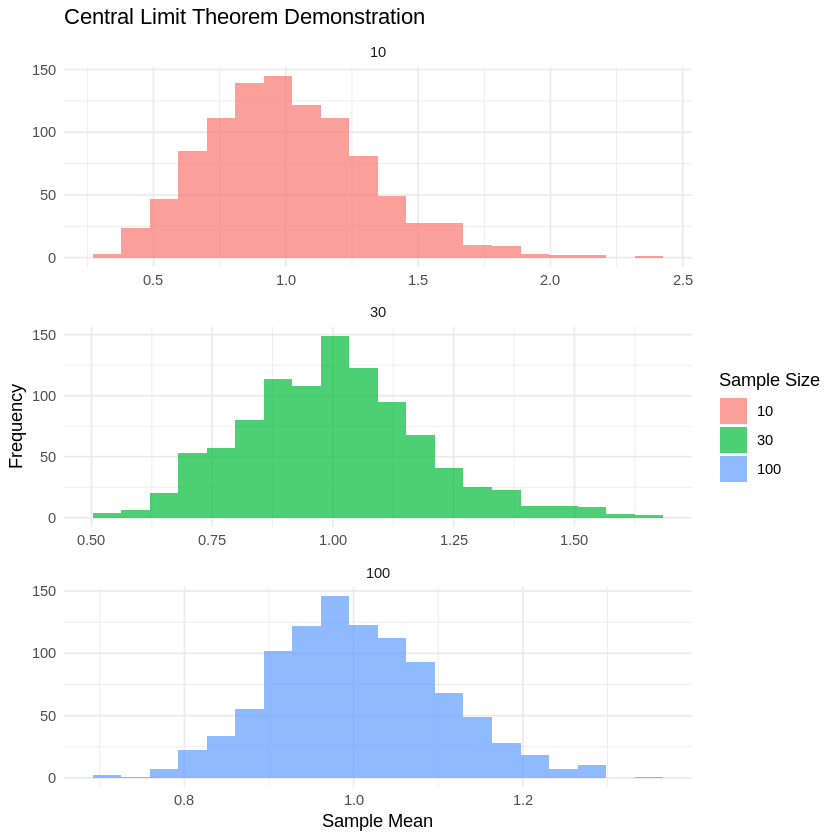

In [47]:
clt_plot

In [ ]:
# Save the outputs

In [48]:
stargazer(model_ols,model_math,model_literacy, model_interaction, type='text')



                                                                       Dependent variable:                                         
                               ----------------------------------------------------------------------------------------------------
                                    totalscore_std          mathscoreraw_std           litscore_std            totalscore_std      
                                         (1)                      (2)                      (3)                       (4)           
-----------------------------------------------------------------------------------------------------------------------------------
tracking                               0.138***                 0.125***                 0.122***                 0.137***         
                                       (0.026)                  (0.026)                  (0.026)                   (0.049)         
                                                                           

In [49]:
stargazer(model_ols,model_math,model_literacy, model_interaction, type = "html", title = "Table 1: results",
          out = "models.html")


<table style="text-align:center"><caption><strong>Table 1: results</strong></caption>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4"><em>Dependent variable:</em></td></tr>
<tr><td></td><td colspan="4" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td>totalscore_std</td><td>mathscoreraw_std</td><td>litscore_std</td><td>totalscore_std</td></tr>
<tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">tracking</td><td>0.138<sup>***</sup></td><td>0.125<sup>***</sup></td><td>0.122<sup>***</sup></td><td>0.137<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.026)</td><td>(0.026)</td><td>(0.026)</td><td>(0.049)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:lef

In [50]:
data.frame(Age_Balance_Test = balance_age$p.value,
                     Gender_Balance_Test = balance_gender$p.value,
                     Baseline_Score_Balance_Test = balance_baseline_score$p.value)

Age_Balance_Test,Gender_Balance_Test,Baseline_Score_Balance_Test
<dbl>,<dbl>,<dbl>
1.836241e-06,0.08805998,0.2543251


In [51]:
data.frame(RESET_Test_pvalue = reset_test$p.value,
                     BP_Test_pvalue = bp_test$p.value)

,RESET_Test_pvalue,BP_Test_pvalue
,<dbl>,<dbl>
BP,1,0.3285517
